## Image mosaic

#### On grading

The homework is graded on a scale from 0 to 100. For each question we indicate how many points you can get. If the answer is not completely correct but nonetheless on the right track, we may decide to give partial credit.

For this homework we require **45 points** or more to pass. If you score below this threshold, the homework will count as failed.

In [1]:
%matplotlib inline
from skimage import data, io, draw, color, transform
from skimage.io import imshow
import imageio
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.transform import rescale
import skimage.transform

# Make figures larger
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In this first part of the homework you will be constructing your very own photographic mosaic. A photographic mosaic is an image where the pixels (or rather small patches) have been replaced by tiny but complete images. In other words, the image is made out of other images. It is a cute idea and delightfully meta, so it is no wonder it is very popular on the internet. People have, for instance, created an image of a character from [Harry Potter](http://orig04.deviantart.net/d3f5/f/2010/320/7/4/deathy_hallows_snape___mosaic_by_smallrinilady-d330420.jpg) made out of frames from the movies. 

First some terminology. In the homework we refer to the overall image as the *background image*. In the example above, this would be Harry Potter. The tiny images, which are building blocks for the background image, are *replacement images*, since they replace parts of the background image. These would be the frames of the movies.

The creation of the mosaic is split into two tasks:

1. **Make tiles**. Divide the background image into tiles. You can think of each tile as a separate, smaller image.
2. **Image similarity search**. For each tile, find the most similar image from the collection of replacement images and substitute the tile.

## Make tiles

### Ex. 1.1: Reading the file and shaping the image (20 points)

Begin by reading in the background image from the file `kangaroo.jpg` and store a reference in a variable called `bg_image`. As you have probably guessed it is not Harry Potter.

<img src="kangaroo.jpg" /> 

Our tiles will be $32 \times 32$ pixels. This turns out to be a convenient choice, because our pool of replacement images are also $32 \times 32$ pixels, and therefore no resizing will be necessary.

After you have read the image file, you should perform the following operations:

1. Convert the integer representation of the image to a float representation using the appropriate `skimage` function.
2. Rescale the image to 120% of the original size.
3. Adjust the shape of `bg_image` to fit exactly a whole number of squares. Here you should not scale the image, but simply throw away any excess rows and columns.

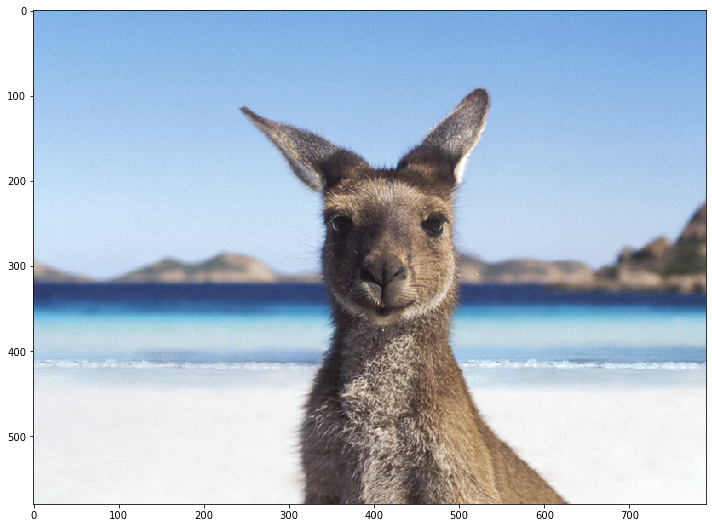

In [2]:
tile_size = 32

bg_image = imageio.imread("/Users/lasserogers/Dropbox/IT & Cognition/1. Semester/Scientific Programming/Assignment 3/kangaroo.jpg")
imshow(bg_image)

(672, 928, 3)


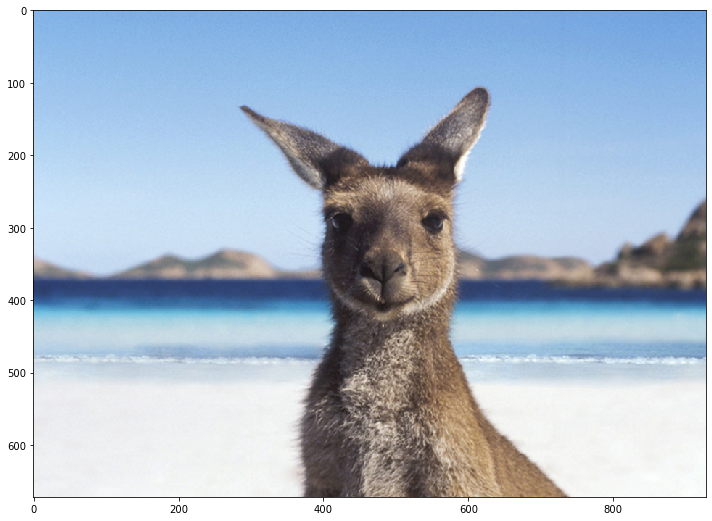

In [3]:
#Convert the integer representation of the image to a float representation using the appropriate skimage function.
bg_image_1 = skimage.img_as_float64(bg_image)

#Rescale the image to 120% of the original size.
rescaled_image = skimage.transform.resize(bg_image_1,(int(bg_image_1.shape[0]*1.2), (int(bg_image_1.shape[1]*1.2))))

#Adjust the shape of bg_image to fit exactly a whole number of squares. 
#Here you should not scale the image, but simply throw away any excess rows and columns.

rows    = (rescaled_image.shape[0]//(tile_size))*(tile_size)
columns = (rescaled_image.shape[1]//(tile_size))*(tile_size)

resized_image = skimage.transform.resize(bg_image_1, (rows, columns))

imshow(resized_image)
print(resized_image.shape)

### Ex. 1.2: Tile coordinates (24 points)

Tiles can be arranged spatially in rows and columns, similarly to pixels. We can thus ask what pixels the tile at the $i$th row and the $j$th column span. 

Below you must finish the implementation of the function `tile_coordinates`, which gives the answer to just that question. The function should return two 1-dimensional arrays, the first providing the row coordinates of the given tile, and the second providing the column coordinates. 

These arrays may then be used to index the pixels of the background image as shown here:

```
    ii, jj = tile_coordinates(1, 3, tile_size)
    tile = bg_image[ii, jj] # Indexes tile (1, 3)
```

To demonstrate that this actually works you should use `tile_coordinates` to create a new image `low_res` in which each of the tiles of the background image is replaced by the *mean color* of that tile. Although the new image will have same number of pixels as the background image, it will appear to be of much lower resolution, because each tile has a single, uniform color.

Display the `low_res` image using `imshow`.

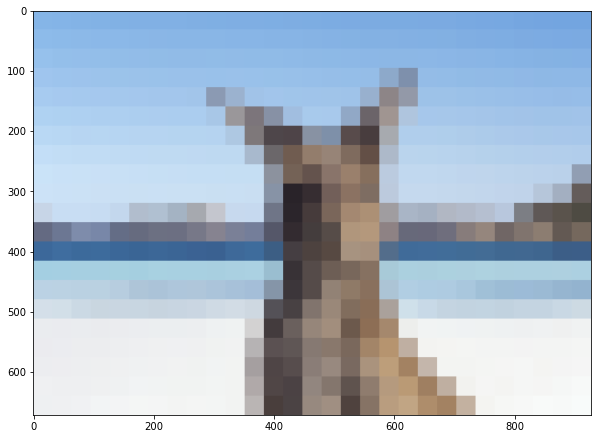

In [4]:
def tile_coordinates(i, j, tile_size):
    row_1       = np.array([], dtype=int)
    column_1    = np.array([], dtype=int)
    
    for n in range(tile_size*i, tile_size*(i+1)):
        row_1 = np.append(row_1, n)
        
    for k in range(tile_size*j, tile_size*(j+1)):
        column_1 = np.append(column_1, k)
    
    return row_1, np.vstack(column_1)

low_resolution = np.zeros(resized_image.shape)

for l in range(resized_image.shape[0]//tile_size):
    for c in range(resized_image.shape[1]//tile_size):
        ii, jj = tile_coordinates(l, c, tile_size)
        tile = np.mean(resized_image[ii,jj], axis=(0,1))
        low_resolution[ii,jj] = tile
        
plt.imshow(low_resolution)

## Image similarity search

Having completed the above assigment you actually have most of the moving parts in place for the photographic mosaic. What remains now is identify images from the pool of replacement images that are similar (in some sense) to the tiles they are replacing.

The first task is to load the set of replacement images. 

### Ex. 1.3: Load the replacement images (10 points)

Go to the [dataset homepage](http://www.cs.toronto.edu/~kriz/cifar.html) and click the download link for the *CIFAR-10 Python version*. Make sure you get the right edition. This downloads a compressed file `cifar-10-python.tar.gz`, which you should place in same directory as the notebook file. Decompress the file using whichever utility you are most comfortable with. Once the contents of the file are extracted, the directory of the notebook should contain a subdirectory named `cifar-10-batches-py`.

We provide a load function `load_cifar10` in the `cifar` module, which takes a filename parameter and returns a 4-dimensional `numpy` array with image data, along with a 1-dimensional array of labels. A label encodes the category of an image. The labels are not required for this assigment, but you *can* use them if you would like to, say, constrain your replacement images to a certain category of images. Think kittens!

You can use the images from only one batch, for example, `data_batch_1`, but feel free.

In [5]:
from cifar import load_cifar10
replacements, replacement_labels = load_cifar10("cifar-10-batches-py/data_batch_1")


Show a random image from the collection. The code should show a new random image each time the cell is executed.

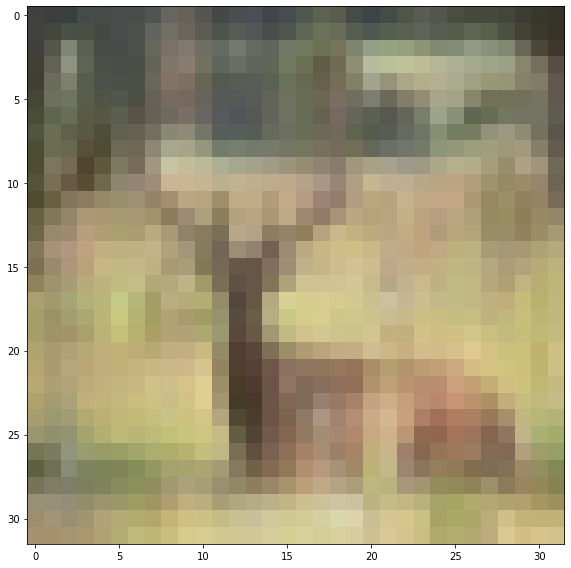

In [6]:
imshow(replacements[np.random.randint(0,10000)])

### Image search

This process of finding a similar replacement image works exactly the same for all the tiles, so let us zoom in on a single tile. The basic idea is to represent both the tile and possible replacement images as vectors and measure the distance between them. A low distance between a tile and a replacement image means they are similar and consequently that the replacement image is a good candidate. The best candidate is of course the one that minimizes the distance.

One way to think about the problem of finding replacement images is in terms of an image search engine. You supply a *query image* and an *image collection*. In return you get a ranked list of the most similar images from the collection. 

We have provided two functions that implement parts of this process. The function `image_distance_query` calculates the distance between query images and all images of a collection, and `plot_best_matches` visualizes the query images alongside the top $k$ matches. 

One crucial ingredient is missing, though, and the quality of the image retrieval is entirely dependent on it. Below we ask you to write several versions of a function that converts raw images into vectors that can be compared. (You should not have to change anything in the cell following this text).

In [7]:
from scipy.spatial.distance import cdist

def image_distance_query(query_images, collection_images, to_vector_fn, p=2):
    query_vecs = [to_vector_fn(image).reshape(1, -1) for image in query_images]
    query_vecs = np.concatenate(query_vecs)

    collection_vecs = [to_vector_fn(image).reshape(1, -1) for image in collection_images]
    collection_vecs = np.concatenate(collection_vecs)

    return cdist(query_vecs, collection_vecs, 'minkowski', p=p)

def plot_best_matches(distances, query_images, collection_images, top_k=5):
    fig, axes = plt.subplots(nrows=distances.shape[0], ncols=top_k+1, squeeze=False,
                             figsize=(top_k*2, distances.shape[0]*2))

    for i in range(distances.shape[0]):
        top_indices = distances[i].argsort().ravel()
        for j in range(top_k):
            ax = axes[i, j+1]
            ax.axis('off')
            plt.sca(ax)
            top_index = top_indices[j]
            imshow(collection_images[top_index])
            ax.set_title("Top " + str(j + 1) + " match")
        
        ax = axes[i, 0]
        ax.set_title("Query image")
        ax.axis('off')
        plt.sca(ax)
        imshow(query_images[i])



### Ex 1.4: Average color vector (20 points)

The `image_distance_query` function takes an argument `to_vector_fn`, which should be a function that converts a 2-dimensional image to a 1-dimensional array (or vector). As stated above the quality of the image retrieval depends critically on how you define this function. 

To get started we ask that you finish the implementation of the function `average_color`, which simply returns the mean RGB color across all pixels.

Calculate distances and visualize by way of `image_distance_query` and `plot_best_matches`. Designate 5 images from the replacement pool as query images. Use a subset of the replacement images (e.g. 1000) as long as you are developing your code, but switch to the full set before you hand in your homework.

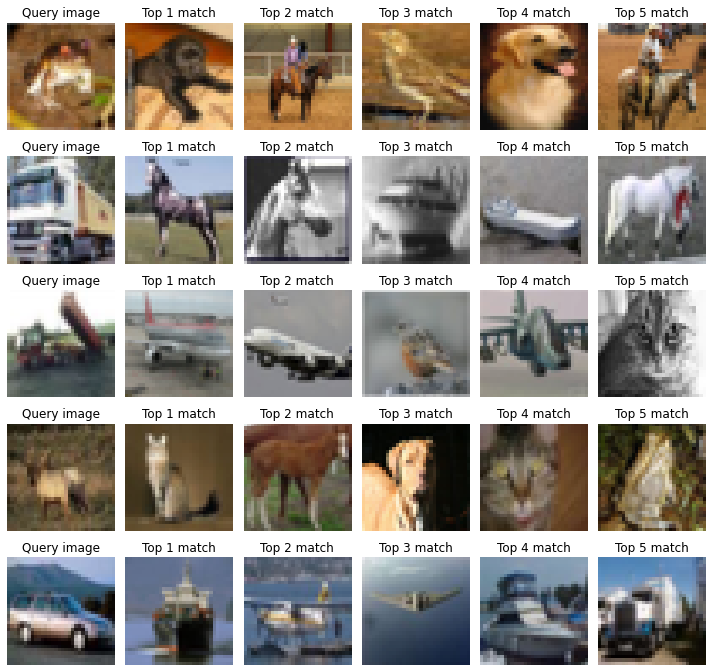

In [8]:
def average_color(image_rgb):
    return np.mean(image_rgb, axis = (0,1))

query_images = replacements[np.arange(0,5)]

collection_images = replacements[np.arange(5,10000)]

distances = image_distance_query(query_images, collection_images, average_color, p=2)

plot_best_matches(distances, query_images, collection_images, top_k=5)

### (OPT) Ex 1.5: 8 by 8 grayscale

Create a new function that first reduces the images to grayscale, then resizes the $32 \times 32$ input image to an $8 \times 8$ image by taking the mean pixel intensity in all $4 \times 4$ squares. (You can check if there is a function in `skimage` that does this). Finally flatten the image to one dimension before returning.

Calculate distances and visualize as before.

In [ ]:
# Your code here

### (OPT) Ex 1.6: Hue histogram

Create a function that converts the image to HSV colorspace, creating a histogram on the hue (first) channel. Note that the edges of the bins should be fixed, otherwise they will not be comparable across images.

Calculate distances and visualize as before.

In [ ]:
# Your code here

### (OPT) Ex 1.7: Joint hue and saturation histogram

Extend the function from the previous assigment to create a joint histogram over the hue and saturation channels. As before the bins should be fixed. Use the function `np.histogram2d` to create the histograms.

In [ ]:
# Your code here

### (OPT) Ex 1.8: Any other strategy you might think of

Here is a chance to be creative. Mixing strategies is also a possiblity.

In [ ]:
# Your code here (possibly)

### Ex 1.9: Render photographic mosaic (26 points)

Take the best image-to-vector function from above and use it together with `image_distance_query` to build your image mosaic. You may reuse some of the code you used to plot the `low_res` image. 

For computational efficiency you should make sure to only call `image_distance_query` once, and not inside of the loop!

In [9]:
m_i =np.zeros(bg_image_1.shape)
q_i = []
c_i = replacements 



x   = bg_image_1.shape[0]
y   = bg_image_1.shape[1]
s_x = x/tile_size
s_y = y/tile_size

for z in range(int(s_x)):
    for b in range(int(s_y)):
        ii,jj = tile_coordinates(z,b,tile_size)
        tile = bg_image_1[ii,jj]
        q_i.append(tile)
        
q_i = np.array(q_i)

dist = image_distance_query(q_i,c_i,average_color,p=2)

for z in range(int(s_x)):
    for b in range(int(s_y)):
        k          = z * int(s_x) + b
        t_i        = dist[1].argsort().ravel()
        s = c_i[top_indices[0]]
        
        ii,jj = tile_coordinates(z,b,tile_size)
        m_i[ii,jj] = replace
        
imshow(m_i)

#plot_best_matches(dist, q_i, c_i, top_k=5)


#My logic is that we must first extract our query images, which will be our tiles from our background image. 
#We do not need to calculate the average of each tile yet, because it is done with image_distance_query. 
#We also have our collection images (replacements). 
#Then we just need to review every single tile in our image and insert the image that has the best match 
#(shortest distance between the vectors). 
#However, I just could not make it work ..

NameError: name 'top_indices' is not defined

In [ ]:
# If you wish to save your mosaic in a separate image, uncomment the line below
#io.imsave("mosaic.jpg", mosaic_image)

### Image collections

Here is a small list of free image sources in case you would like to use other (or larger) images for your mosaic.

- [CIFAR-10](http://www.vision.ee.ethz.ch/datasets_extra/pec/). The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. 
- [Food-101](http://www.vision.ee.ethz.ch/datasets_extra/food-101/). We introduce a challenging data set of 101 food categories, with 101,000 images. All images were rescaled to have a maximum side length of 512 pixels.
- [MIRFLICKR-25000](http://press.liacs.nl/mirflickr/mirdownload.html). 25,000 images from Flickr. 